In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import xmeos
from xmeos import models
from xmeos import datamod

CONSTS = models.CONSTS

In [5]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [6]:
eos_mod = analysis['eos_mod']
data = analysis['datasets']['Spera2011']
eos_electronic = analysis['eos_electronic']
# data = analysis['datasets']['multi']

param_tex_str = analysis['param_tex_str']
params_init = analysis['params_init']

eos_mod.set_params(params_init)
# display(eos_mod.get_params())
datamodel = datamod.init_datamodel(data, eos_mod)


In [7]:
datamodel

{'bulk_mod_wt': None,
 'data': {'T_avg': [2564.1111111111113,
   3051.3333333333335,
   3543.625,
   4038.125,
   4510.7142857142853,
   5013.666666666667],
  'T_labels': array([ 2500.,  3000.,  3500.,  4000.,  4500.,  5000.]),
  'V_labels': array([  6.28513062,   6.46819268,   6.66223846,   6.8905927 ,
           7.08748772,   7.45333549,   7.85585744,   8.30630551,
           8.87446513,   9.65457853,  10.54061593,  11.60567601,
          12.11197166,  12.7130795 ,  13.3768607 ,  14.17358824]),
  'datasource': 'data/MgSiO3-Oganov-md-Spera2011.csv',
  'exp_constraint': {'KT': None,
   'P': array(0),
   'T': array(1673),
   'V': array(12.803751383249672),
   'alpha': None,
   'wt': 10},
  'mass_avg': 20.080000000000002,
  'table':             V     T       P          E  trust  Verr  Terr  Perr      Eerr  \
  0   14.173588  2559   -0.88 -20.738626   True     0    19  0.19  0.000083   
  1   14.173588  3058   -0.77 -20.569655   True     0    22  0.21  0.000021   
  2   14.173588  3537   

In [8]:
print('Calc Params')
print('===========')
eos_mod.get_calc_params()

Calc Params


{'bcoef': ['_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4', 'V0'],
 'compress': ['V0', 'K0', 'KP0'],
 'gamma': ['V0', 'gamma0', 'gammap0'],
 'refstate': ['V0', 'S0', 'E0'],
 'thermal': ['mexp', 'Cvlimfac']}

In [9]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)

In [10]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True, wt_vol=.5)

In [11]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99976470458148559, 'P': 0.9998527485126415, 'V': 0.99860484051986254}

'Model Residual Error = '

{'E': 0.0058222776008625392, 'P': 0.6264728407072585, 'V': 0.10136190245295786}

,name,value,error
0,V0,12.949250,0.017640
1,K0,13.200057,0.193723
2,KP0,8.238372,0.048639
3,E0,-20.595341,0.001899
4,gamma0,0.189943,0.005303
5,gammap0,-1.940244,0.034831
6,_bcoef_0,0.982133,0.009691
7,_bcoef_1,0.614998,0.059765
8,_bcoef_2,1.310489,0.272608
9,_bcoef_3,-3.040360,1.735552


In [12]:
# Save fitted model
analysis['datamodel'] = datamodel
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)

<IPython.core.display.Javascript object>


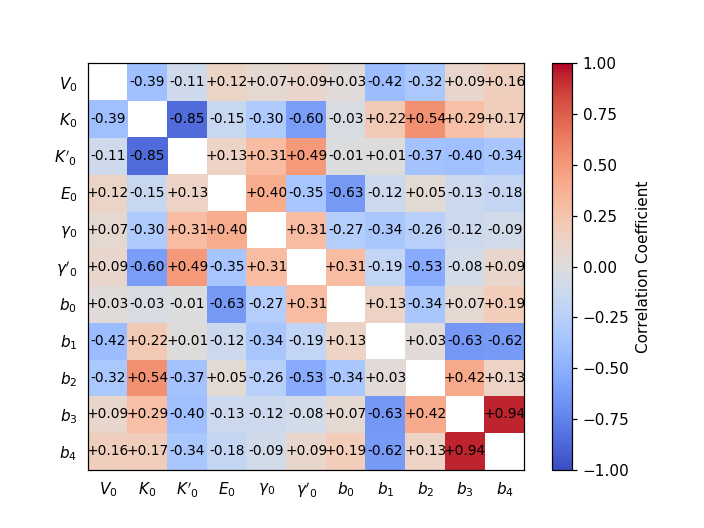

In [13]:
plt.figure()

posterior = datamodel['posterior']
corr = posterior['corr']
if corr is not None:

    param_labels = [param_tex_str[name] for name in posterior['param_names']]


    cmap = plt.get_cmap('coolwarm')
    Nparam = len(param_labels)

    corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
    plt.pcolormesh(corr_plt,cmap=cmap)


    # plt.imshow(corr, cmap=cmap)
    plt.clim(-1,1)
    plt.colorbar(label=r'Correlation Coefficient')

    plt.xticks(.5+np.arange(len(param_labels)),param_labels)
    plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

    for (index,val) in np.ndenumerate(np.flipud(corr)):
        if index[1]!=Nparam-1-index[0]:
            plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                     horizontalalignment='center', verticalalignment='center')

    plt.setp(plt.gca().get_xticklines(),visible=False);
    plt.setp(plt.gca().get_yticklines(),visible=False);


#plt.plot((0,11),(5,5),'k-',linewidth=2)
#plt.plot((0,11),(7,7),'k-',linewidth=2)
#plt.plot((4,4),(0,11),'k-',linewidth=2)
#plt.plot((6,6),(0,11),'k-',linewidth=2)
#plt.show()



In [14]:
eos_mod = datamodel['eos_mod']
T0 = eos_mod.get_refstate()['T0']
V0 = eos_mod.get_params()['V0']
tbl = datamodel['data']['table']
Tlbl = data['T_labels']
delT = Tlbl[1]-Tlbl[0]

cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.3,1.2,1001)

<IPython.core.display.Javascript object>


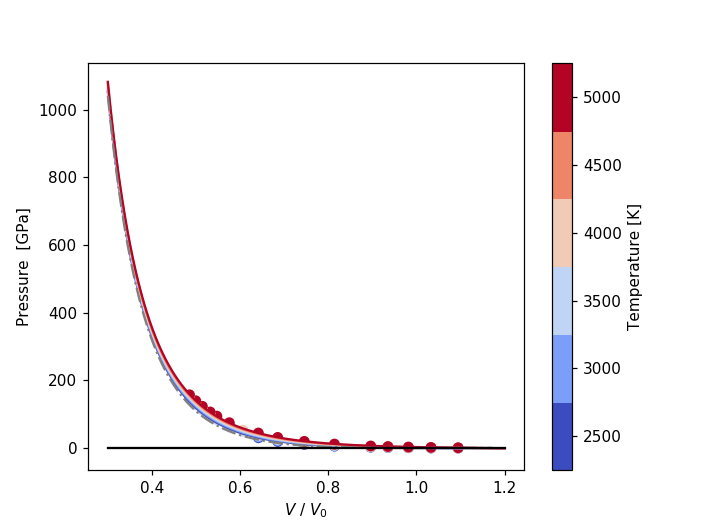

In [15]:
plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)


Tbnd = 1773
Tbnd = 1673
Pbnd = eos_mod.press(Vmod,Tbnd)
# indbnd = np.argmin(Pbnd)
indbnd = np.argmin(Pbnd**2)


plt.plot(Vmod[:indbnd]/V0, Pbnd[:indbnd],'-.',color=[.5,.5,.5])
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

#plt.ylim(-2,15);
plt.plot(Vmod/V0,0*Vmod,'k-')




<IPython.core.display.Javascript object>


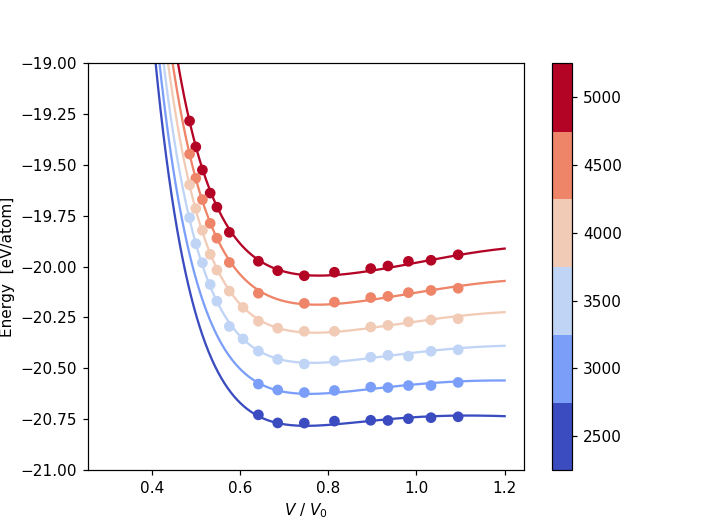

(-21, -19)

In [16]:
plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)
plt.ylim(-21,-19)

<IPython.core.display.Javascript object>


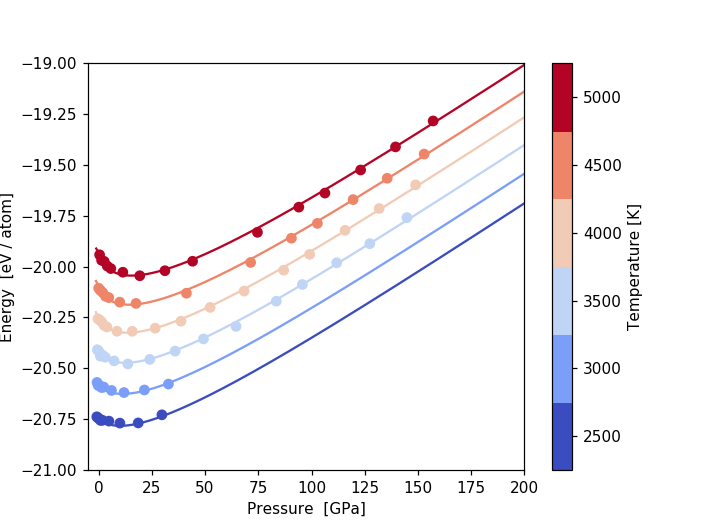

(-21, -19)

In [17]:
plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(eos_mod.press(Vmod,iT), eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['P'], tbl['E'], c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'Pressure  [GPa]')
plt.ylabel(r'Energy  [eV / atom]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

plt.xlim(-5, 200)
plt.ylim(-21, -19)

In [25]:
eos_electronic.set_param_values(param_names='V0', param_values=V0)
E_elec = eos_electronic.energy(tbl['V'], tbl['T'])
P_elec = eos_electronic.press(tbl['V'], tbl['T'])

In [40]:
T_avg = data['T_avg']
T_avg.append(8000)

<IPython.core.display.Javascript object>


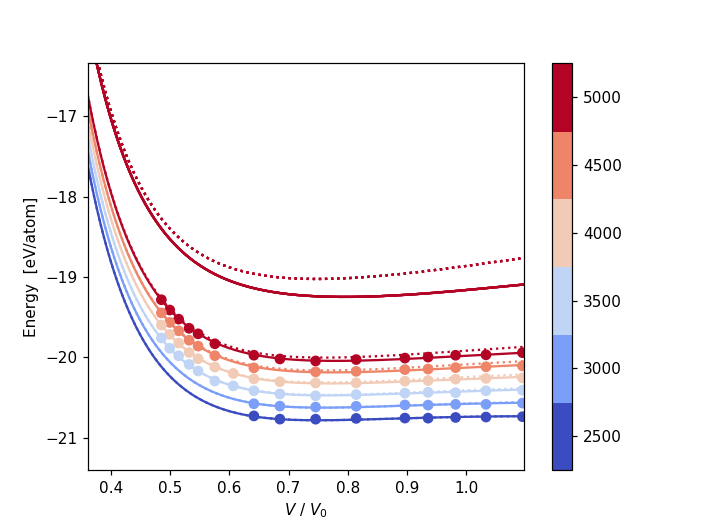

(-21, -19)

In [41]:
plt.figure()
for iT in T_avg:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT)+eos_electronic.energy(Vmod, iT), ':', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)
plt.ylim(-21,-19)

<IPython.core.display.Javascript object>


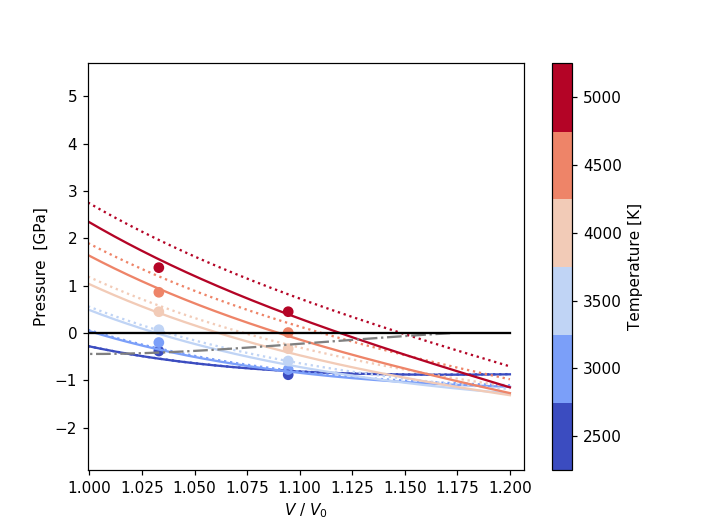

In [29]:
plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT)+eos_electronic.press(Vmod, iT), ':', color=icol)


Tbnd = 1773
Tbnd = 1673
Pbnd = eos_mod.press(Vmod,Tbnd)
# indbnd = np.argmin(Pbnd)
indbnd = np.argmin(Pbnd**2)


plt.plot(Vmod[:indbnd]/V0, Pbnd[:indbnd],'-.',color=[.5,.5,.5])
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

#plt.ylim(-2,15);
plt.plot(Vmod/V0,0*Vmod,'k-')

<IPython.core.display.Javascript object>


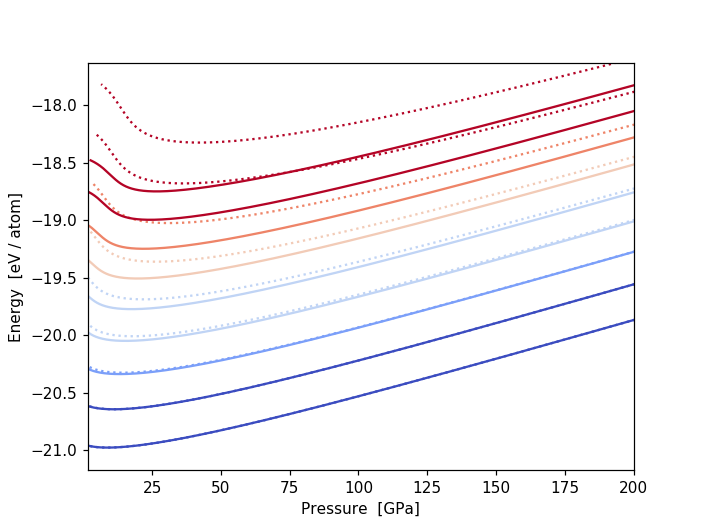

(-5, 200)

In [50]:
T_avg = [2000,3000,4000,5000,6000,7000,8000,9000,10000]
plt.figure()
clims = [1850,10250]
for iT in T_avg:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(eos_mod.press(Vmod,iT)+eos_electronic.press(Vmod, iT), 
             eos_mod.internal_energy(Vmod,iT)+eos_electronic.energy(Vmod, iT), ':', color=icol)
    plt.plot(eos_mod.press(Vmod,iT), 
             eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    

plt.xlabel(r'Pressure  [GPa]')
plt.ylabel(r'Energy  [eV / atom]')
# cbar = plt.colorbar(label='Temperature [K]')
# cbar.set_ticks(Tlbl)

plt.xlim(-5, 200)
# plt.ylim(-21, -19)